In [1]:
!nvidia-smi

Mon Jan  9 19:23:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0    15W /  80W |     39MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cd src && python deploy/ONNX/export_onnx.py --weights runs/train/yolov6s6_cat/weights/best_ckpt.pt --img 640 --dynamic-batch --end2end --ort

In [2]:
import cv2
import time
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [3]:
cuda = True
w = "/home/hoangphuc/Documents/wowAI/src/runs/train/yolov6s6_cat/weights/best_ckpt.onnx"
imgList = [cv2.imread('img_test/cat_dog.jpg'),
           cv2.imread('img_test/cat_dog2.jpg'),
           cv2.imread('img_test/cat_dog3.jpg'),
           cv2.imread('img_test/cat_person.jpg'),
           cv2.imread('img_test/cats.jpg')]


In [4]:
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

/home/hoangphuc/miniconda3/envs/wowAI/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [5]:
names = ['cat']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [6]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [7]:
origin_RGB = []
resize_data = []
for img in imgList:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    origin_RGB.append(img)
    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)
    im = image.astype(np.float32)
    resize_data.append((im,ratio,dwdh))

In [8]:
np_batch = np.concatenate([data[0] for data in resize_data])
np_batch.shape

(5, 3, 640, 640)

In [9]:
outname = [i.name for i in session.get_outputs()]
outname

['num_dets', 'det_boxes', 'det_scores', 'det_classes']

In [10]:
inname = [i.name for i in session.get_inputs()]
inname

['images']

In [11]:
# batch 5 infer
im = np.ascontiguousarray(np_batch/255)
out = session.run(outname,{'images':im})


In [12]:
for i in range(len(imgList)):
    image = origin_RGB[i]
    num = out[0][i][0]
    ratio,dwdh = resize_data[i][1:]
    for obj in range(num):
        x0,y0,x1,y1 = out[1][i][obj]
        score = out[2][i][obj]
        cls_id = out[3][i][obj]
        box = np.array([x0,y0,x1,y1])
        box -= np.array(dwdh*2)
        box /= ratio
        box = box.round().astype(np.int32).tolist()
        cls_id = int(cls_id)
        score = round(float(score),3)
        if score <= 0.5:
            continue
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(image,box[:2],box[2:],color,2)
        cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[0, 0, 0],thickness=2)

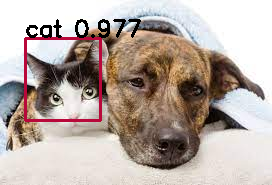

In [13]:
Image.fromarray(origin_RGB[0])

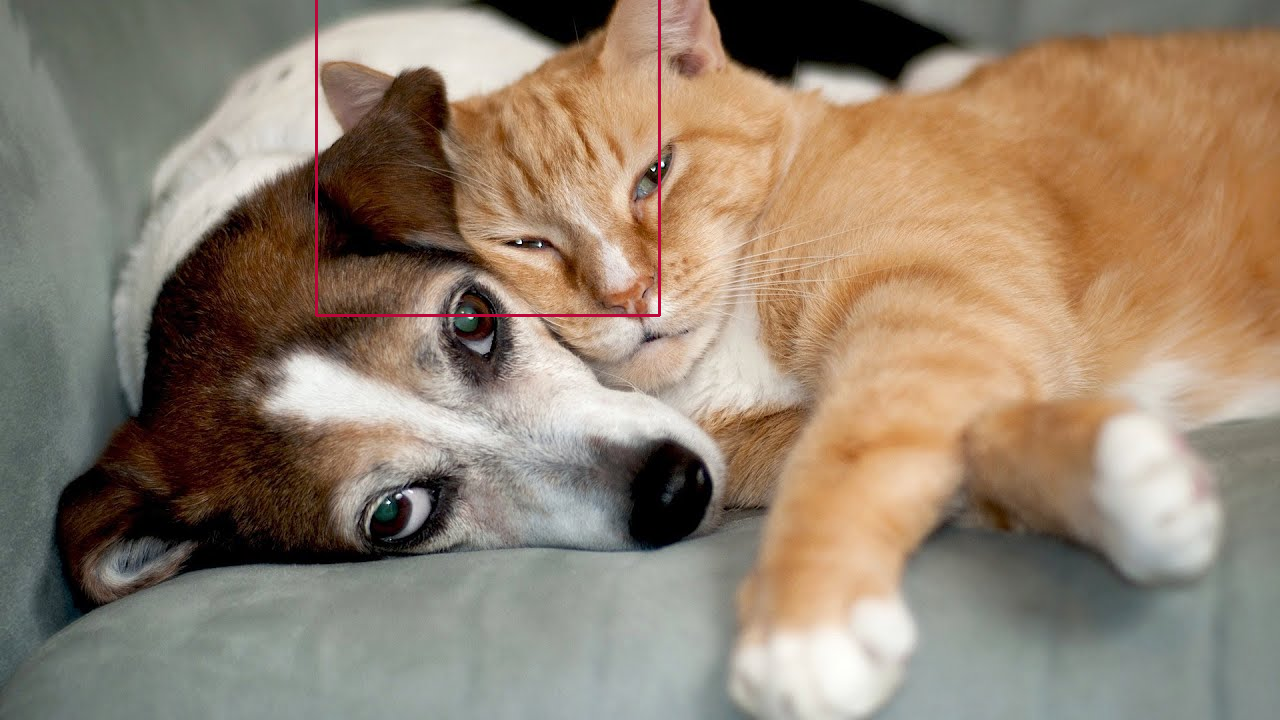

In [14]:
Image.fromarray(origin_RGB[1])

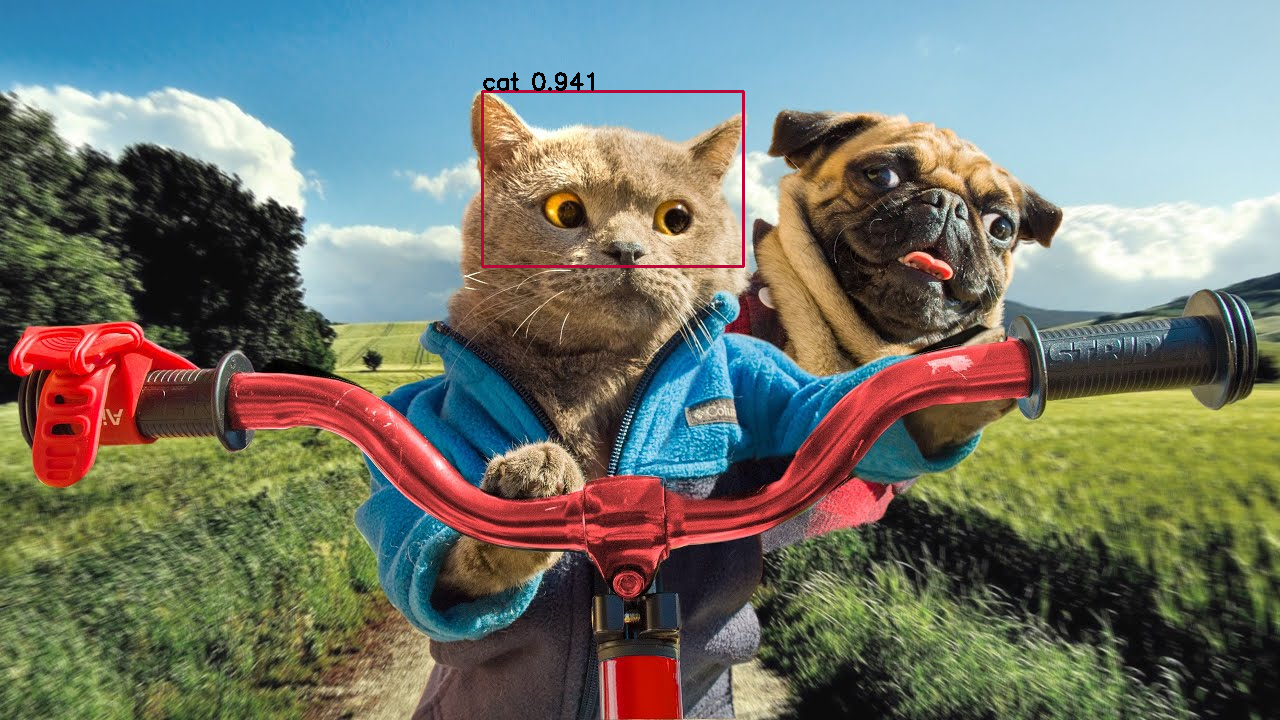

In [15]:
Image.fromarray(origin_RGB[2])

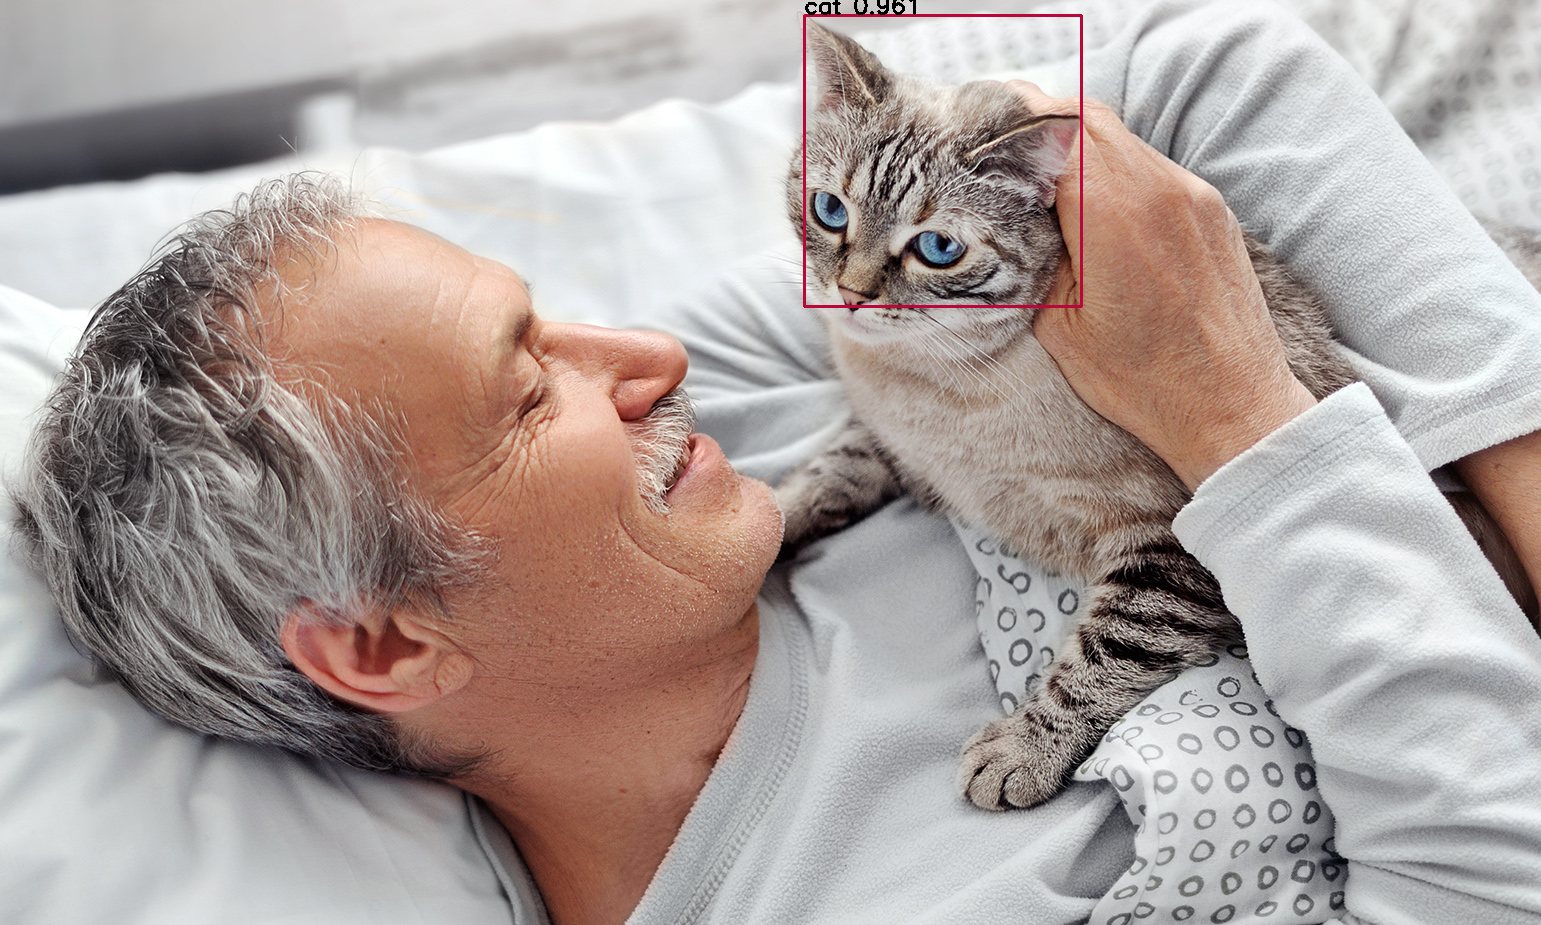

In [16]:
Image.fromarray(origin_RGB[3])

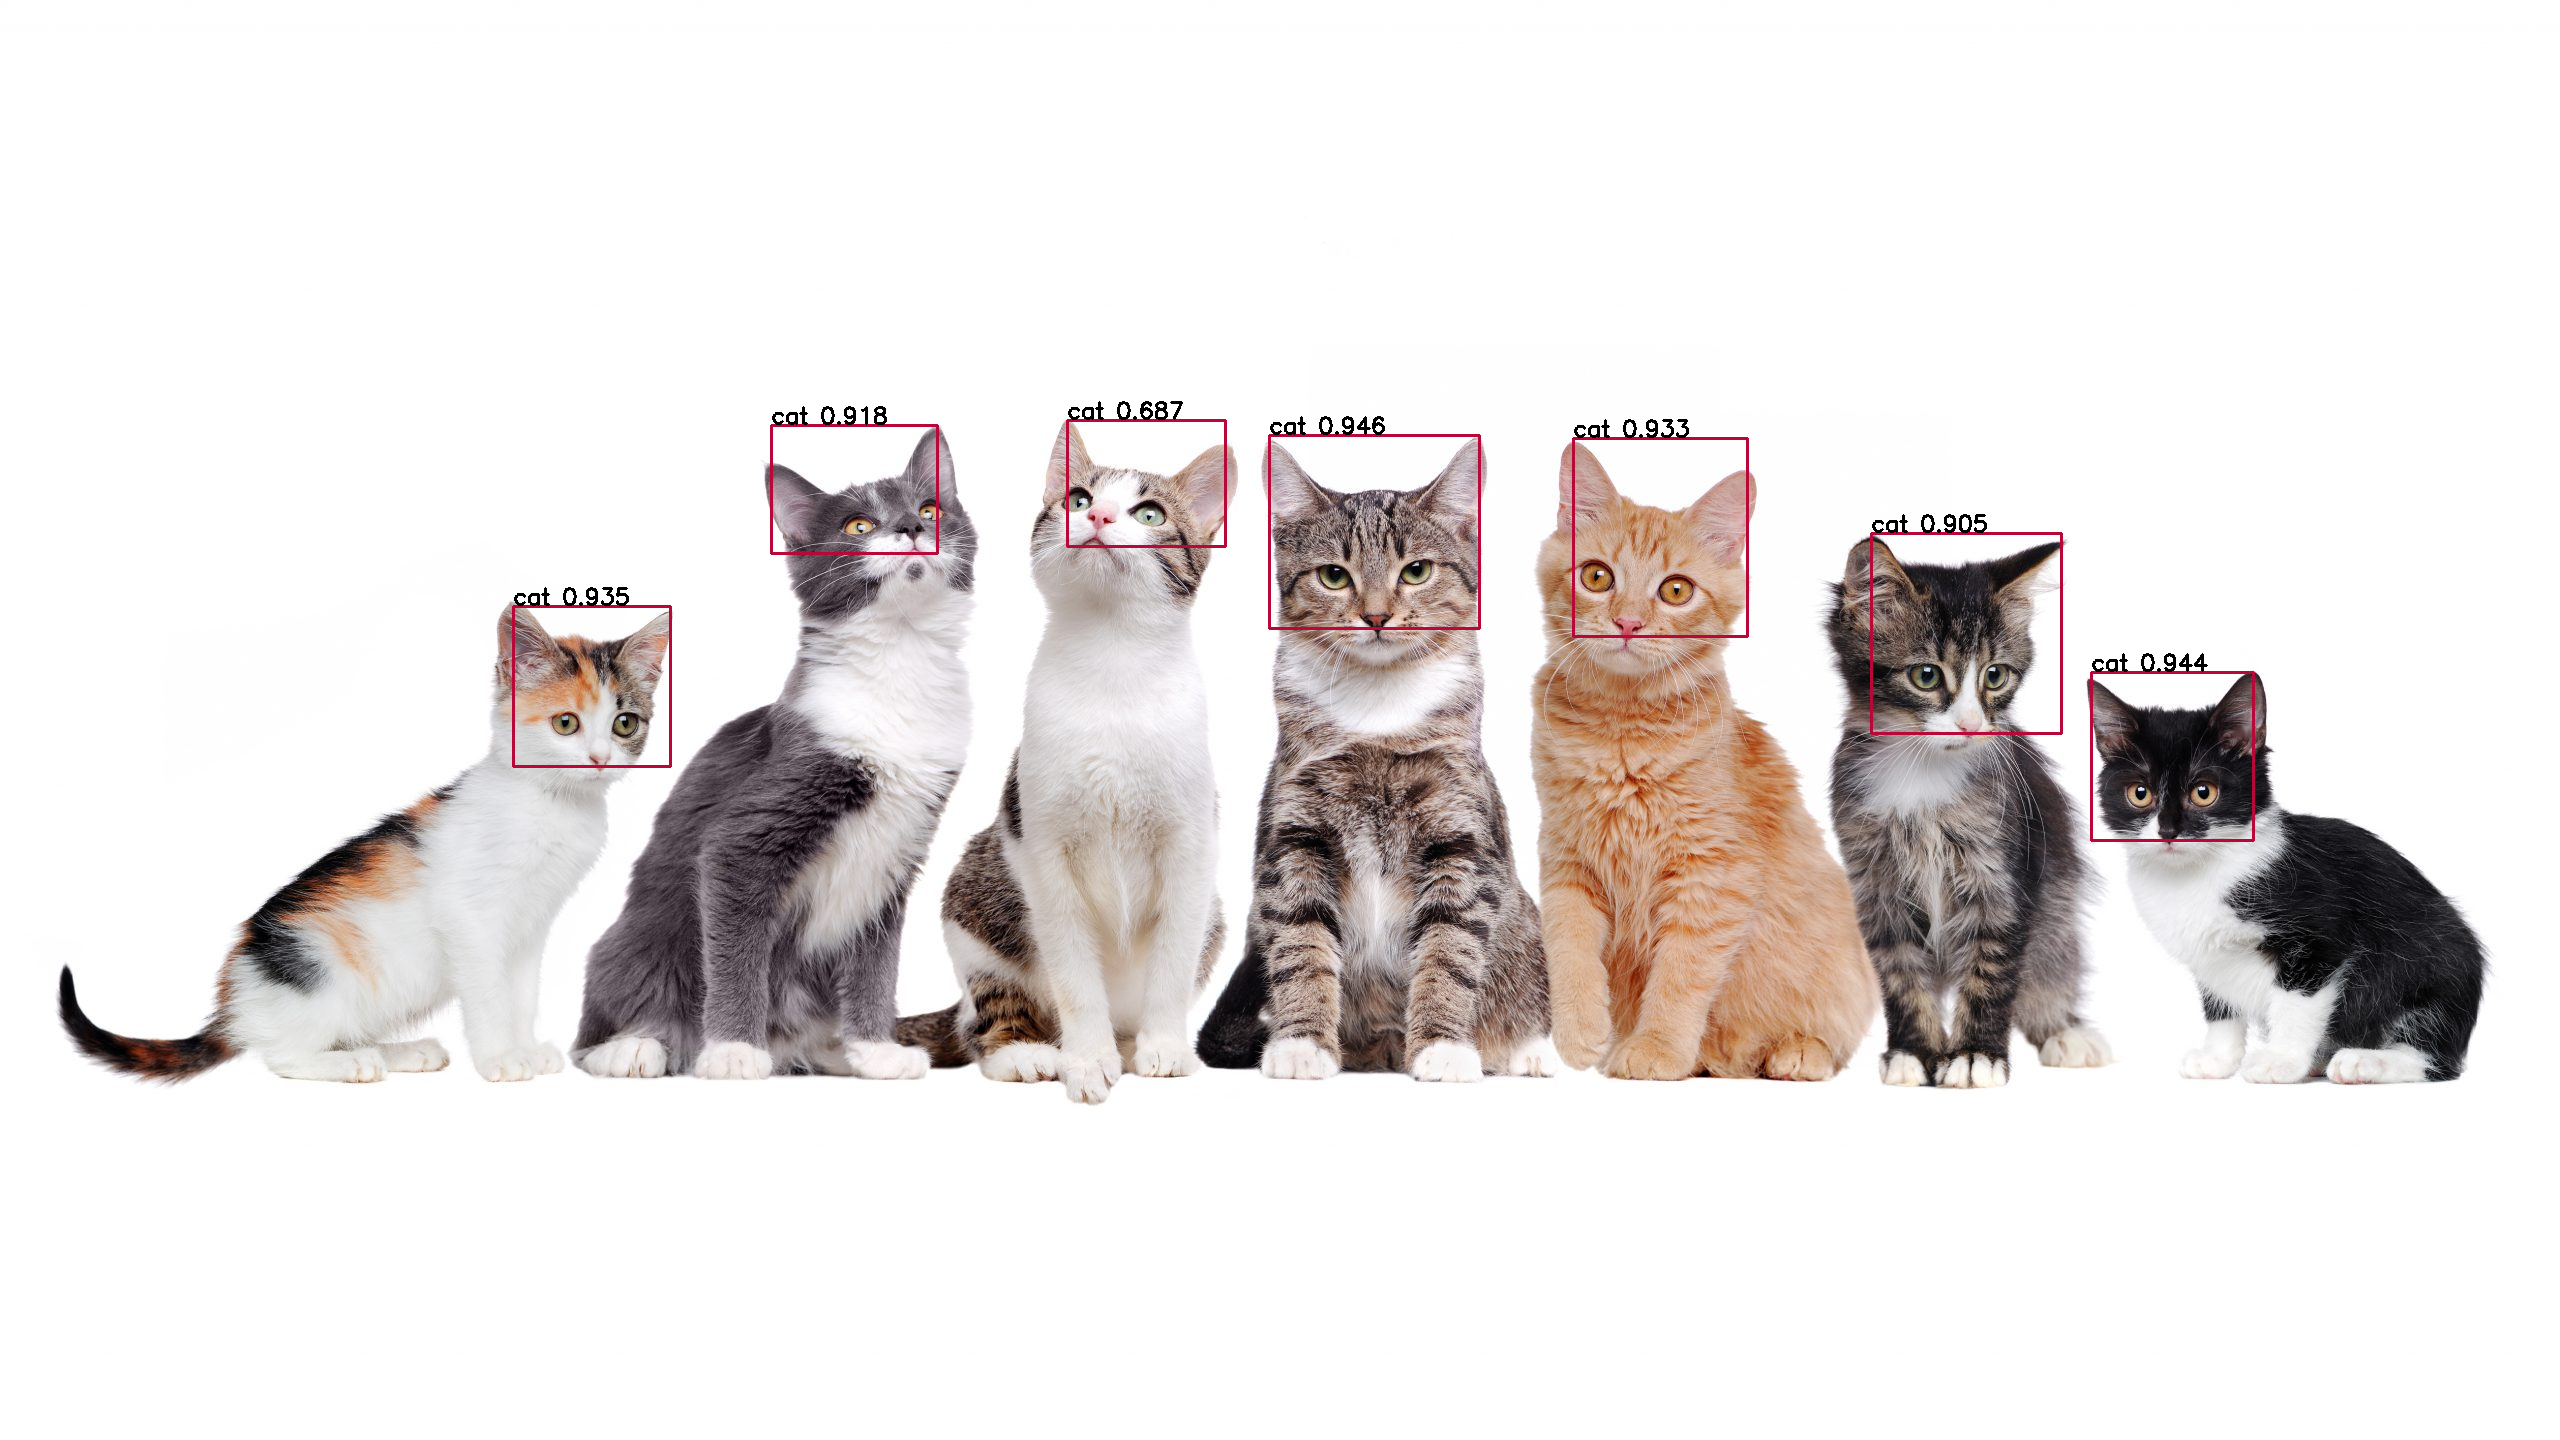

In [17]:
Image.fromarray(origin_RGB[4])